# Butina Clustering

Clustering is an important aspect of analysing molecules arising from small molecule design. Generative algorithms often produce (tens of) thousands of molecules resulting in an overwhelming data to analyse.

Chemists often wish to group the highly similar molecules amongst these and pick the best one for further, more computational intensive analysis, like FEP calculations.

Here, we will explore butina clustering on how to cluster molecules from a given dataset and visualise them in each cluster

In [21]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

In [2]:
# Consider a sample dataset

data = pd.read_csv('data/test_molecules.csv')
print(data.shape)
data.head(3)

(1971, 11)


,Item Name,M.w.,Solvent,Formula,SMILES,Solubility,Form,Pathway,Target,Information,URL
0,Angiotensin II,1046.2,H2O,C50H71N13O12,CCC(C)C(C(=O)NC(CC1=CN=CN1)C(=O)N2CCCC2C(=O)NC...,"?100.2mg/mL in H2O, <2.09mg/mL in DMSO",NaN,Cardiovascular,Angiotensin Receptor,NaN,http://www.apexbt.com/search.php?catalog=A1042
1,Levetiracetam,170.21,DMSO,C8H14N2O2,CCC(C(=O)N)N1CCCC1=O,>8.5mg/mL in DMSO,Free Base,Membrane Transporter/Ion Channel,Calcium Channel,Antiepileptic drug,http://www.apexbt.com/search.php?catalog=A1198
2,Daptomycin,1620.67,DMSO,C72H101N17O26,CCCCCCCCCC(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)NC(CC...,>81.1mg/mL in DMSO,Free Base,DNA Damage/DNA Repair,DNA Synthesis,Calcium-dependent antibiotic,http://www.apexbt.com/search.php?catalog=A1206


In [ ]:
# remove faulty smiles:
from utils_pack import hello_world, remove_faulty_smiles

#test.say_hello()

new_data = remove_faulty_smiles.remove(data, 'SMILES')

In [4]:
print(f"There are {new_data.shape[0]} entries in the new dataframe")
new_data.head(2)

There are 1957 entries in the new dataframe


,Item Name,M.w.,Solvent,Formula,SMILES,Solubility,Form,Pathway,Target,Information,URL
0,Angiotensin II,1046.2,H2O,C50H71N13O12,CCC(C)C(C(=O)NC(CC1=CN=CN1)C(=O)N2CCCC2C(=O)NC...,"?100.2mg/mL in H2O, <2.09mg/mL in DMSO",NaN,Cardiovascular,Angiotensin Receptor,NaN,http://www.apexbt.com/search.php?catalog=A1042
1,Levetiracetam,170.21,DMSO,C8H14N2O2,CCC(C(=O)N)N1CCCC1=O,>8.5mg/mL in DMSO,Free Base,Membrane Transporter/Ion Channel,Calcium Channel,Antiepileptic drug,http://www.apexbt.com/search.php?catalog=A1198


In [ ]:
# Clean and sanitize the smiles:

from utils_pack import clean_sanitize

new_df = clean_sanitize.df_standardize(new_data, 'SMILES')

In [7]:
new_df.head(2)

,Item Name,M.w.,Solvent,Formula,SMILES,Solubility,Form,Pathway,Target,Information,URL,ok_smiles
0,Angiotensin II,1046.2,H2O,C50H71N13O12,CCC(C)C(C(=O)NC(CC1=CN=CN1)C(=O)N2CCCC2C(=O)NC...,"?100.2mg/mL in H2O, <2.09mg/mL in DMSO",NaN,Cardiovascular,Angiotensin Receptor,NaN,http://www.apexbt.com/search.php?catalog=A1042,CCC(C)C(NC(=O)C(Cc1ccc(O)cc1)NC(=O)C(NC(=O)C(C...
1,Levetiracetam,170.21,DMSO,C8H14N2O2,CCC(C(=O)N)N1CCCC1=O,>8.5mg/mL in DMSO,Free Base,Membrane Transporter/Ion Channel,Calcium Channel,Antiepileptic drug,http://www.apexbt.com/search.php?catalog=A1198,CCC(C(N)=O)N1CCCC1=O


In [9]:
# remove duplicates

final_df = new_df.drop_duplicates(subset=['ok_smiles'])

print(f"There were {len(new_df) - len(final_df)} duplicates in the dataframe")

There were 189 duplicates in the dataframe


In [10]:
# Create mol object:

final_df['mol'] = final_df['ok_smiles'].apply(Chem.MolFromSmiles)

/var/folders/zs/218995x90vx9h_djl280wv2m0000gn/T/ipykernel_54462/3900400854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['mol'] = final_df['ok_smiles'].apply(Chem.MolFromSmiles)


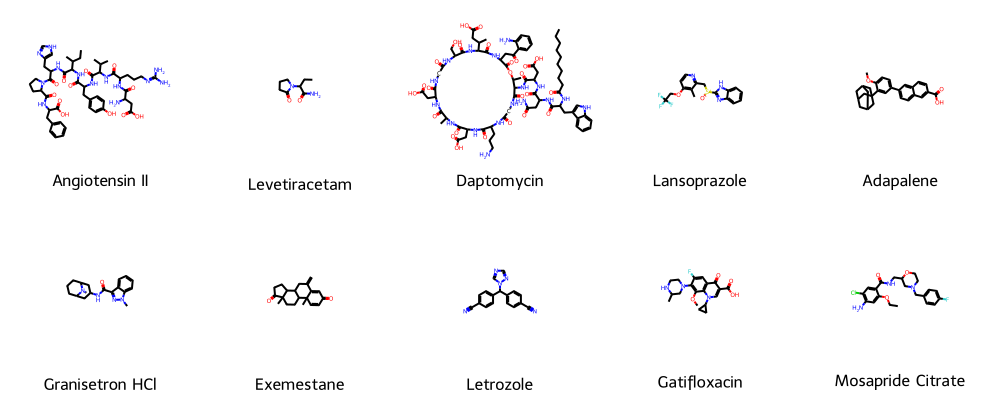

In [14]:
# Visualise how the molecules look like:

mols = final_df['mol'][:10] #take the top 20 entries of mols column
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG = False, legends=list(final_df['Item Name'][:20].values))

In [15]:
# We define the butina clustering function:

def butina_cluster(mol_list, cutoff=0.84): #this cutoff is relaxed, since the dataset is already diverse
    
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list] #we use larger radius and #bits since the dataset is already diverse
    
    dists = []
    
    nfps = len(fp_list) #fp_list is the collection of all molecule fingerprints
    
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(  #Compare fingerprints here
            fp_list[i], fp_list[:i]) 
        
        dists.extend([1-x for x in sims])
    
    mol_clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData = True) #gives list of groups of molecules (their index). The first group belongs to cluster 1, second group is cluster 2, so on  
    
    cluster_id_list = [0] * nfps
    
    for idx, cluster in enumerate(mol_clusters, 1):   #idx is the cluster number/id   #cluster is the group of molecule indices
        for member in cluster:                        #member is molecule index number
            cluster_id_list[member] = idx
    
    return cluster_id_list

In [22]:
final_df['cluster'] = butina_cluster(final_df.mol)

/var/folders/zs/218995x90vx9h_djl280wv2m0000gn/T/ipykernel_54462/3698774762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['cluster'] = butina_cluster(final_df.mol)


In [23]:
final_df.head(3)

,Item Name,M.w.,Solvent,Formula,SMILES,Solubility,Form,Pathway,Target,Information,URL,ok_smiles,mol,cluster
0,Angiotensin II,1046.2,H2O,C50H71N13O12,CCC(C)C(C(=O)NC(CC1=CN=CN1)C(=O)N2CCCC2C(=O)NC...,"?100.2mg/mL in H2O, <2.09mg/mL in DMSO",NaN,Cardiovascular,Angiotensin Receptor,NaN,http://www.apexbt.com/search.php?catalog=A1042,CCC(C)C(NC(=O)C(Cc1ccc(O)cc1)NC(=O)C(NC(=O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x15cf38190>,2
1,Levetiracetam,170.21,DMSO,C8H14N2O2,CCC(C(=O)N)N1CCCC1=O,>8.5mg/mL in DMSO,Free Base,Membrane Transporter/Ion Channel,Calcium Channel,Antiepileptic drug,http://www.apexbt.com/search.php?catalog=A1198,CCC(C(N)=O)N1CCCC1=O,<rdkit.Chem.rdchem.Mol object at 0x15cf38200>,37
2,Daptomycin,1620.67,DMSO,C72H101N17O26,CCCCCCCCCC(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)NC(CC...,>81.1mg/mL in DMSO,Free Base,DNA Damage/DNA Repair,DNA Synthesis,Calcium-dependent antibiotic,http://www.apexbt.com/search.php?catalog=A1206,CCCCCCCCCC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(...,<rdkit.Chem.rdchem.Mol object at 0x15cf38270>,4


In [24]:
print(f"Choosing a cutoff of 0.84 gives us {max(final_df.cluster)} total number of clusters")

Choosing a cutoff of 0.84 gives us 314 total number of clusters


In [25]:
final_df['cluster'].value_counts()

cluster
1      174
6       78
2       78
3       72
17      53
      ... 
221      1
302      1
182      1
255      1
227      1
Name: count, Length: 314, dtype: int64

### Visualise a cluster:

In [33]:
num = 34 #pick a random cluster number, say #33

new_data_cluster = final_df[final_df['cluster'] == num] 

In [34]:
print(f"There are {new_data_cluster.shape[0]} molecules in the cluster {num}")

There are 3 molecules in the cluster 34


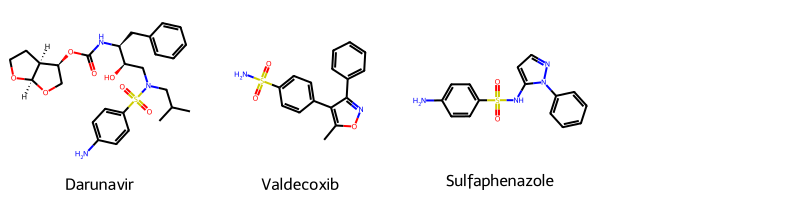

In [35]:
# It seems we have been successful in clustering molecules that are structurally similar:
Draw.MolsToGridImage(new_data_cluster['mol'], molsPerRow=4, useSVG = False, legends=list(new_data_cluster['Item Name'].values))